In [1]:
cd G:\MOPITT\Download

G:\MOPITT\Download


In [2]:

import os
import harp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from cmcrameri import cm
import requests
import sentinelsat
import shutil
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patheffects as path_effects

In [3]:
filename = "S5P_OFFL_L2__SO2____20221026T230145_20221027T004315_26099_03_020401_20221028T203457.nc"
so2_basic = harp.import_product(filename)

In [4]:
print(so2_basic)

source product = 'S5P_OFFL_L2__SO2____20221026T230145_20221027T004315_26099_03_020401_20221028T203457.nc'

int scan_subindex {time=1877400}
double datetime_start {time=1877400} [seconds since 2010-01-01]
float datetime_length [s]
long orbit_index
long validity {time=1877400}
float latitude {time=1877400} [degree_north]
float longitude {time=1877400} [degree_east]
float latitude_bounds {time=1877400, 4} [degree_north]
float longitude_bounds {time=1877400, 4} [degree_east]
float sensor_latitude {time=1877400} [degree_north]
float sensor_longitude {time=1877400} [degree_east]
float sensor_altitude {time=1877400} [m]
float solar_zenith_angle {time=1877400} [degree]
float solar_azimuth_angle {time=1877400} [degree]
float sensor_zenith_angle {time=1877400} [degree]
float sensor_azimuth_angle {time=1877400} [degree]
double pressure {time=1877400, vertical=34} [Pa]
float SO2_column_number_density {time=1877400} [mol/m^2]
float SO2_column_number_density_uncertainty_random {time=1877400} [mol/m^

In [5]:
print(so2_basic.SO2_column_number_density_validity)

type = byte
dimension = {time=1877400}
valid_min = -128
valid_max = 127
description = 'continuous quality descriptor, varying between 0 (no data) and 100 (full quality data)'
data =
[0 0 0 ... 0 0 0]



In [6]:
operations = ";".join([
    "SO2_column_number_density_validity>50",
    "keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,SO2_column_number_density)",
    "derive(datetime_stop {time} [days since 2000-01-01])",
    "derive(datetime_start [days since 2000-01-01])",
    "exclude(datetime_length)",
    "bin_spatial(721,-90,0.25,1441,-180,0.25)", # lat_cells, corner_lat, lat_resolution, lon_cells, corner_lon, lon_resolution, 
    "derive(SO2_column_number_density [DU])",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})",
])

In [7]:
reduce_operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"

In [9]:
filenames = r"S5P_OFFL_L2__SO2____20221026T*.nc"

In [10]:
merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)

In [11]:
print(merged)

history = "2023-01-03T12:33:45Z [harp-1.15.1] harp.import_product('S5P_OFFL_L2__SO2____20221026T*.nc',operations='SO2_column_number_density_validity>50;keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,SO2_column_number_density);derive(datetime_stop {time} [days since 2000-01-01]);derive(datetime_start [days since 2000-01-01]);exclude(datetime_length);bin_spatial(721,-90,0.25,1441,-180,0.25);derive(SO2_column_number_density [DU]);derive(latitude {latitude});derive(longitude {longitude})',reduce_operations='squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()')"

double datetime_start {time=1} [days since 2000-01-01]
double SO2_column_number_density {time=1, latitude=720, longitude=1440} [DU]
double datetime_stop {time=1} [days since 2000-01-01]
long count {time=1}
float weight {time=1, latitude=720, longitude=1440}
double latitude_bounds {latitude=720, 2} [degree_north]
double longitude_bounds {longitude=1440, 2} [degree_east]
double latitude 

In [12]:
gridlat = np.append(merged.latitude_bounds.data[:,0], merged.latitude_bounds.data[-1,1])
gridlon = np.append(merged.longitude_bounds.data[:,0], merged.longitude_bounds.data[-1,1])

In [17]:
days  = []
np_dates = np.arange('2022-10-20', '2022-10-27', dtype='datetime64[D]')
dates01 = np.datetime_as_string(np_dates, unit='D')
for i in np.arange(0,(len(dates01))):
    dates0 = dates01[i][0:4]+dates01[i][5:7]+dates01[i][8:10]
    days.append(dates0)

In [18]:
data_f = []

for i in days:
    filenames = r"S5P_OFFL_L2__SO2____"+i+"T*.nc"
    merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)
    data_f.append(merged.SO2_column_number_density.data[0,:,:])
    merged = None


In [19]:
lon = np.arange(-180,180,0.25)
lat = np.arange(-90,90,0.25)

In [20]:
import xarray as xr

so2_xarray = xr.Dataset(
    data_vars={"SO2_vertical_column_density": (("days","lat","lon",),np.array(data_f))
              },
    coords = {"lat":(("lat"),lat,),
              "lon":(("lon"),lon),
              "days":(("days"),days),
              "gridlon":(("gridlon"),gridlon),
              "gridlat":(("gridlat"),gridlat)
             },
            
    
    attrs={'Long_name':'SO2 vertical column density',
           'units':'DU',
           'title': 'Copernicus Sentinel 5P TROPOMI SO2 Column Number Density Validity',
           'dimensions(sizes)': 'lon(1440), lat(720), time(14))',
           'web-site1':'http://www.tropomi.eu/data-products/sulphur-dioxide',
           'web-site2':'https://sentinels.copernicus.eu/documents/247904/3541451/Sentinel-5P-Sulphur-Dioxide-Readme.pdf',
           'Instruction':'Kindly use "gridlon" and "gridlat" variable in plotting "pcolormesh"',
           'Author and mail':'K. Madan Mohan Rao and kmmraoiitm@gmail.com'
          })

In [23]:
so2_xarray.to_netcdf('S5P_TROPOMI_SO2_vertical_column_density.nc4')

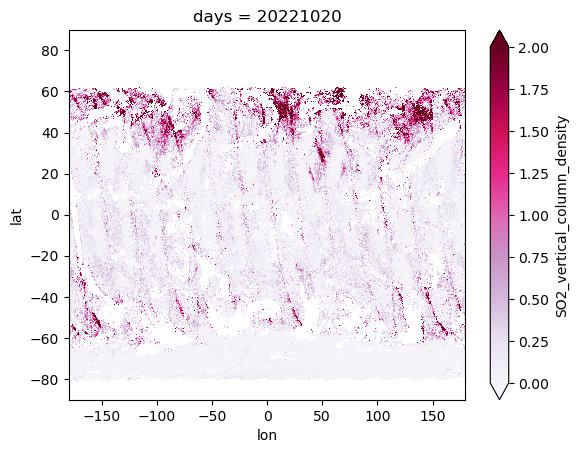

In [28]:
so2_xarray.SO2_vertical_column_density[0,:,:].plot(vmin=0,vmax=2, cmap='PuRd')

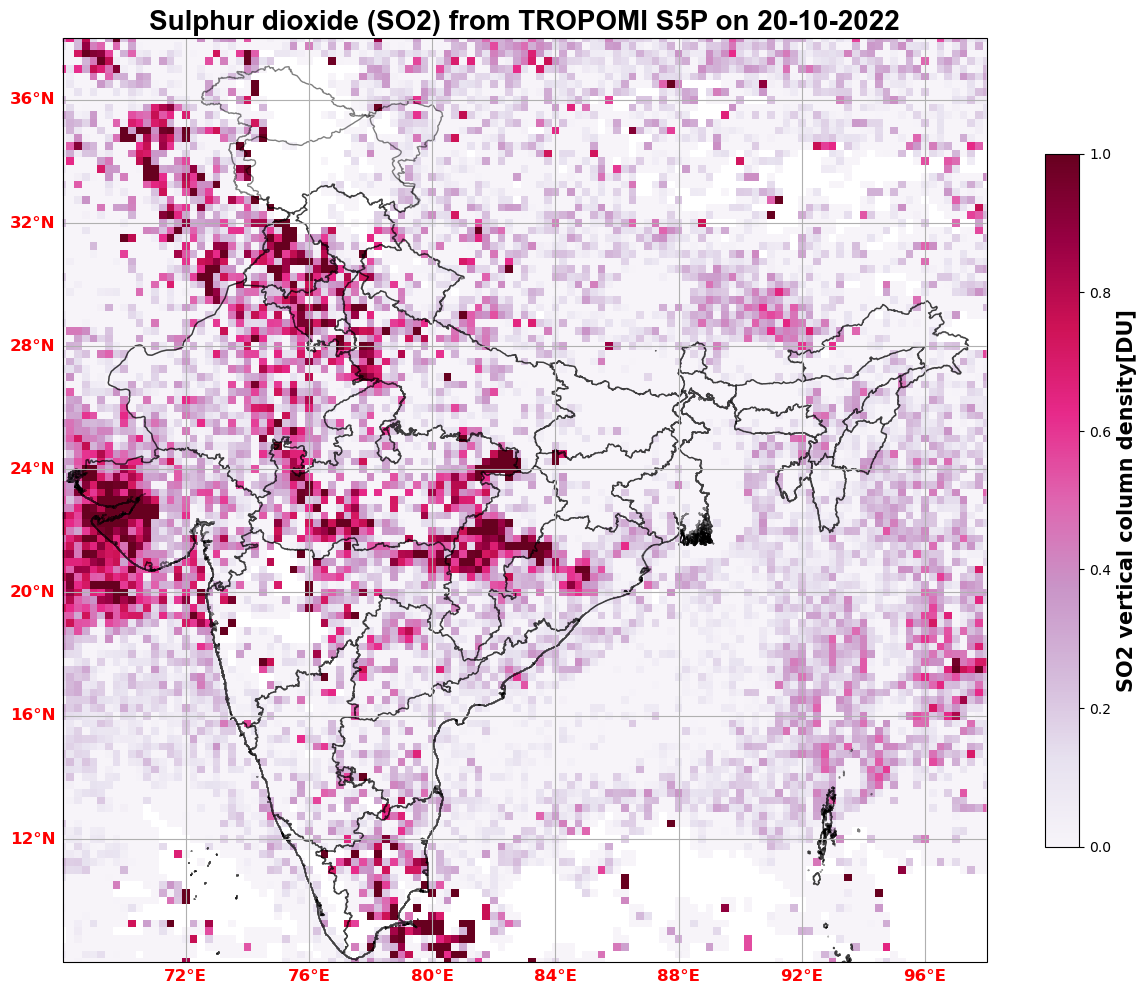

In [31]:
fname= r'F:\Indian Shape Files\Indian Administrative bourders\IND_adm\IND_adm1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())
fname2 = r'F:\Indian Shape Files\Only Indian Boundaries\India_Boundary\India_Boundary.shp'
adm1_shapes2 = list(shpreader.Reader(fname2).geometries())
# fname3 = r'D:\Clip-data-from-netCDF-file-and-plot-using-Cartopy-main\Dharashiv.shp'
# adm1_shapes3 = list(shpreader.Reader(fname3).geometries())

def main():
    plt.figure(figsize=(15,12),facecolor = 'white')
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([68,98,8,38], crs=ccrs.PlateCarree()) # [lonmin,lonmax,latmin,latmax]
#     ax.coastlines()
    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.5,lw = 1, facecolor='none') #
    ax.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.5,lw = 1, facecolor='none') #
#     ax.add_geometries(adm1_shapes3, ccrs.PlateCarree(),
#                   edgecolor='red', alpha=0.5,lw = 2, facecolor='none') #
#     ax.add_feature(cfeature.LAND, edgecolor='black')
#     ax.add_feature(cfeature.BORDERS,lw = 2,edgecolor='red')
#     ax.add_feature(cfeature.STATES.with_scale('10m'),
#                linestyle='-', alpha=.25, facecolor='none',lw = 2, edgecolor='red')
    
#     ax.add_feature(cfeature.COASTLINE)
#     ax.gridlines()
    ax.set_facecolor('white')
    ax.set_title('Sulphur dioxide (SO2) from TROPOMI S5P on 20-10-2022' ,fontweight="bold", size=20,family= 'Arial')
    filled_c = plt.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[0,:,:], 
                              vmin=0, vmax=1, cmap='PuRd', transform=ccrs.PlateCarree())
#     filled_c = plt.imshow( SO2val[0,:,:], vmin=vmin, vmax=vmax, cmap='inferno', transform=ccrs.PlateCarree())
#     ax.plot(lon23102022,lat23102022,markersize=10,marker='^',color='yellow',lw=4,label='23102022')
#     ax.plot(lon24102022,lat24102022,markersize=10,marker='^',color='lime',lw=4,label='24102022')
#     plt.text(76.0420,18.4,'Osmanabad Airport',horizontalalignment='right', color= 'red',fontweight="bold", size=20,family= 'Arial')
#     ax.legend()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(68,98,4))
    gl.ylocator = mticker.FixedLocator(np.arange(8,38,4))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12,'color': 'red', 'weight': 'bold'}
    gl.ylabel_style = {'size': 12,'color': 'red', 'weight': 'bold'}
        # Add a colorbar for the filled contour.
    a = plt.colorbar(filled_c,ax=ax, orientation='vertical',pad=0.05,shrink=0.75)
    a.set_label(label=f'SO2 vertical column density[DU]',weight='bold', fontsize='15')
#     plt.figtext(0.25, 0.085, "\xa9 kmmraoiitm@gmail.com", ha="center", 
#                 fontsize=15)#box={"facecolor": "green", "alpha": 0.75})

if __name__ == '__main__':
    main()
# plt.savefig('SO2_TROPOMI_S5P_on_24102022.jpg',bbox_inches='tight',dpi=720)
plt.show()

In [32]:
era=xr.load_dataset(r'C:\Users\IITM\INDIA_ERA5_14102022_31102022.nc4')
era_daily = era.resample(time='D').mean()

In [33]:
era_daily

<xarray.Dataset>
Dimensions:    (time: 18, longitude: 167, latitude: 155, level: 7)
Coordinates:
  * time       (time) datetime64[ns] 2022-10-14 2022-10-15 ... 2022-10-31
  * longitude  (longitude) float32 60.25 60.5 60.75 61.0 ... 101.2 101.5 101.8
  * latitude   (latitude) float32 38.75 38.5 38.25 38.0 ... 1.0 0.75 0.5 0.25
  * level      (level) int32 400 500 600 700 800 900 1000
Data variables:
    r          (time, level, latitude, longitude) float32 68.39 70.1 ... 80.6
    t          (time, level, latitude, longitude) float32 245.6 245.6 ... 299.7
    u          (time, level, latitude, longitude) float32 17.04 16.94 ... 1.449
    v          (time, level, latitude, longitude) float32 2.024 ... -0.9625
    vo         (time, level, latitude, longitude) float32 -6.412e-06 ... 9.57...

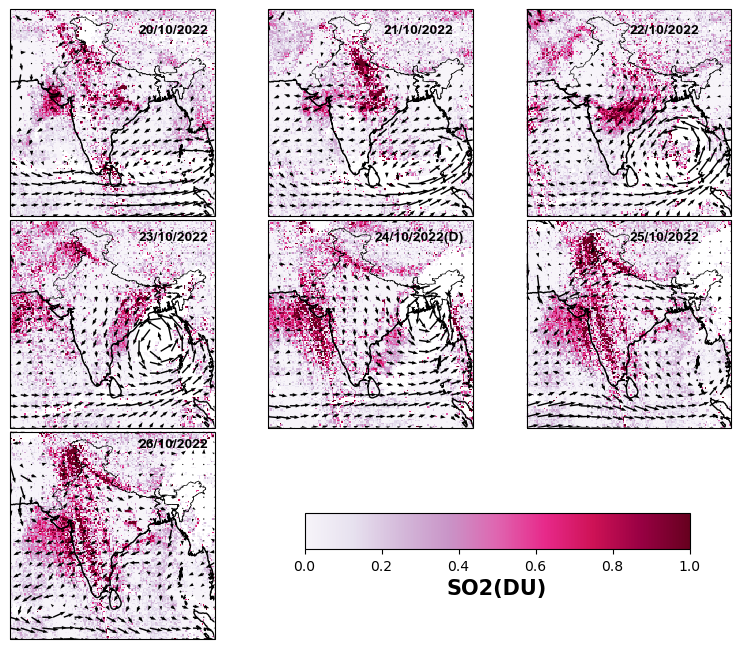

In [41]:
fname= r'F:\Indian Shape Files\Indian Administrative bourders\IND_adm\IND_adm1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())
fname2 = r'F:\Indian Shape Files\Only Indian Boundaries\India_Boundary\India_Boundary.shp'
adm1_shapes2 = list(shpreader.Reader(fname2).geometries())


fig=plt.figure(figsize=(11,9))#,constrained_layout=True)
ax = fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,wspace=0.02, hspace=0.02)


def main():
#***************Total******************************
    ax1 = plt.subplot(3,3, 1, projection=ccrs.PlateCarree())   
    ax1.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
#     ax1.set_title('Total')
    filled_c = ax1.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[0,:,:],
                              transform=ccrs.PlateCarree(),vmin=0, vmax=1,cmap='PuRd')
    ax1.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[6,5,:,:]),np.array(era_daily.v[6,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20) 

    ax1.coastlines('50m') 
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax1.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax1.text(0.8, 0.9, '20/10/2022', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    ax2 = plt.subplot(3,3, 2, projection=ccrs.PlateCarree())   
    ax2.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax2.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[1,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=1,cmap='PuRd')
    ax2.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[7,5,:,:]),np.array(era_daily.v[7,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax2.coastlines('50m')
    #     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax2.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax2.text(2, 0.9,'21/10/2022', horizontalalignment='center', verticalalignment='center', 
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    
    ax3 = plt.subplot(3,3, 3, projection=ccrs.PlateCarree())   
    ax3.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax3.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[2,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=1,cmap='PuRd')
    ax3.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[8,5,:,:]),np.array(era_daily.v[8,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax3.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax3.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax3.text(3.2,0.9,'22/10/2022', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    ax4 = plt.subplot(3,3, 4, projection=ccrs.PlateCarree())   
    ax4.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax4.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[3,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=1,cmap='PuRd')
    ax4.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[9,5,:,:]),np.array(era_daily.v[9,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax4.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax4.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax4.text(0.8, -0.1, '23/10/2022', horizontalalignment='center', verticalalignment='center', 
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    ax5 = plt.subplot(3,3,5, projection=ccrs.PlateCarree())   
    ax5.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax5.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[4,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=1,cmap='PuRd')
    ax5.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[10,5,:,:]),np.array(era_daily.v[10,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)

    ax5.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax5.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax5.text(2, -0.1, '24/10/2022(D)', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    
    ax6 = plt.subplot(3,3, 6, projection=ccrs.PlateCarree())   
    ax6.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax6.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[5,:,:],
                            transform=ccrs.PlateCarree(),vmin=0, vmax=1,cmap='PuRd')
    ax6.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[11,5,:,:]),np.array(era_daily.v[5,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax6.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax6.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax6.text(3.2, -0.1, '25/10/2022', horizontalalignment='center', verticalalignment='center', 
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    
    ax7 = plt.subplot(3,3, 7, projection=ccrs.PlateCarree())   
    ax7.set_extent([61.5,99,38.5,0.5], ccrs.PlateCarree())    
    filled_c = ax7.pcolormesh(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[5,:,:],
                            transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='PuRd')
    ax7.quiver(era_daily.longitude,era_daily.latitude,np.array(era_daily.u[12,5,:,:]),np.array(era_daily.v[12,5,:,:]),
               width= 0.007,
               headwidth=2.5,
               headlength=3.5,
               headaxislength=3.5,
               color = 'black',
               regrid_shape=20)
#                 scale=100,scale_units='xy')
    ax7.coastlines('50m')
#     ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax7.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.9,lw = 0.5, facecolor='none') #
    ax7.text(0.8, -1.1, '26/10/2022', horizontalalignment='center', verticalalignment='center',
             fontweight="bold", size=10,color='black',family= 'Arial',transform=ax1.transAxes)
    


#     fig.colorbar(filled_c, ax=ax21, location='bottom')
    
if __name__ == '__main__':
    main()   
    
#ax1 = plt.subplot(3,3, 8, projection=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.2) 
cbar_ax = fig.add_axes([0.39, 0.3, 0.35, 0.04]) #(w= >away from map, x= position up and down, y= width of cbar, z = height cb)
im =cbar_ax.pcolor(so2_xarray.lon, so2_xarray.lat, so2_xarray.SO2_vertical_column_density[5,:,:],vmin=0,vmax=1,cmap='PuRd')#,60, vmin=0, vmax=1, cmap='jet')
#fig.colorbar(im, cax=cbar_ax)
#im.colorbar()
#plt.show()            0.4, 0.25, 0.4, 0.04

a=fig.colorbar(im, ax = ax, orientation = 'horizontal',cax = cbar_ax)

a.set_label(label='SO2(DU)',weight='bold', fontsize='15')
plt.savefig(r'F:\Cyclones\Cyclones\Sitrang\plots\TROPMI_SO2_SITRANG.jpg',bbox_inches='tight',dpi=720)

In [40]:
pwd

'G:\\MOPITT\\Download'